Running epoch 1 of 2
epoch accuracy 0.4309210479259491
Running epoch 2 of 2
epoch accuracy 0.8223684430122375

Final training time: 8.163720607757568
Final training accuracy: 0.8223684430122375
Final training loss: 4.205265522003174

Sample prediction
True label: 34
Prediction: 34
Final test accuracy: 0.8190789222717285


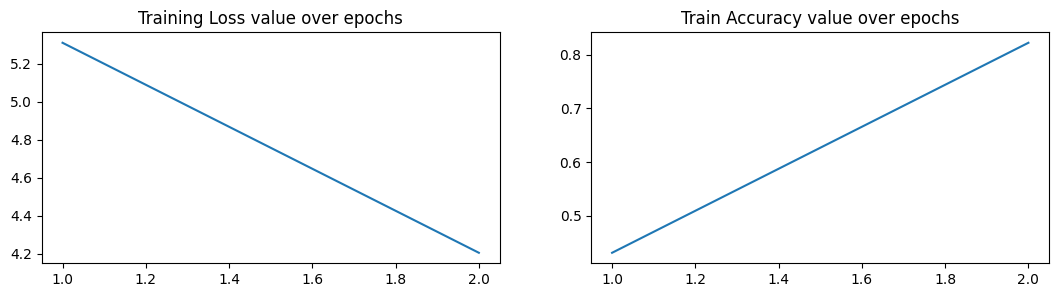

In [13]:
from glob import glob

import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import pil_to_tensor
import torchvision.models as models
from torchvision import transforms
from torch.optim import Adam
import time
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import torchvision.io as io
import re
from PIL import Image
from torchvision.utils import save_image
import os
import math


def train_model(model, n_epochs, train_dl):
    """
    Trains the model

    Args:
      model: the model to train
      n_epochs: the number of epochs to train for
      train_dl: the data loader to train on
    """
    opt = Adam(model.parameters(), lr=1e-3)
    loss_func = nn.CrossEntropyLoss()

    start = time.time()
    losses, accuracies = [], []
    for epoch in range(n_epochs):
        print(f"Running epoch {epoch + 1} of {n_epochs}")

        epoch_losses, epoch_accuracies = [], []
        for batch in train_dl:
            x, y = batch
            batch_loss = train_batch(x, y, model, opt, loss_func)
            epoch_losses.append(batch_loss)
        epoch_loss = np.mean(epoch_losses)

        for batch in train_dl:
            x, y = batch
            batch_acc = accuracy(x, y, model)
            epoch_accuracies.append(batch_acc)
        epoch_accuracy = np.mean(epoch_accuracies)
        print(f"epoch accuracy {epoch_accuracy}")

        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)
    total_time = time.time() - start
    return losses, accuracies, total_time

def evaluate_model(model, test_dl):
    """
    Evaluates the model

    Args:
    model: the model to test
    test_dl: the data loader to test on
    """
    batch_accuracies = []
    for batch in test_dl:
        x, y = batch
        batch_acc = accuracy(x, y, model)
        batch_accuracies.append(batch_acc)

    return np.mean(batch_accuracies)

def train_batch(x, y, model, opt, loss_fn):
    """
    Trains the model on one batch of data

    Args:
    x: the data to train on
    y: the corresponding classifications
    model: the model to train
    opt: the optimizer
    loss_fn: the loss function
    """
    model.train()

    opt.zero_grad()                    # Flush memory
    batch_loss = loss_fn(model(x), y)  # Compute loss
    batch_loss.backward()              # Compute gradients
    opt.step()                         # Make a GD step

    return batch_loss.detach().cpu().numpy()

@torch.no_grad()
def accuracy(x, y, model):
    """
    Calculates the accuracy of the model

    Args:
    x: the data to test on
    y: the corresponding classifications
    model: the model to test
    """
    model.eval()

    prediction = model(x)
    argmaxes = prediction.argmax(dim=1)
    s = torch.sum((argmaxes == y).float())/len(y)

    return s.cpu().numpy()

def display_results(train_loss, train_accuracy, train_time, test_accuracy, n_epochs, model, testloader):
    """
    Shows the results for the given model:
      graphs of training loss and accuracy over training epochs
      final training time, accuracy, and loss
      sample prediction
      test accuracy
    
    Args:
    train_loss: the losses over the training epochs
    train_accuracy: the accuracies over the training epochs
    train_time: the total training time
    test_accuracy: the accuracy on the test data
    n_epochs: number of epochs
    model: the model to test
    model_name: the name of the model
    testloader: the data loader of the testing data
    """
    
    plt.figure(figsize=(13,3))
    plt.subplot(121)
    plt.title(f'Training Loss value over epochs')
    plt.plot(np.arange(n_epochs) + 1, train_loss)
    plt.subplot(122)
    plt.title(f'Train Accuracy value over epochs')
    plt.plot(np.arange(n_epochs) + 1, train_accuracy)

    print("")
    print(f"Final training time: {train_time}")
    print(f"Final training accuracy: {train_accuracy[-1]}")
    print(f"Final training loss: {train_loss[-1]}")
    
    images, labels = next(iter(testloader))
    
    single_image = images[0]  
    single_label = labels[0]  
    
    output = model(single_image.unsqueeze(0))
    output_cpu = output.cpu().detach()
    predicted_class = np.argmax(output_cpu.numpy())

    print("")
    print("Sample prediction")
    print(f"True label: {single_label.item()}")
    print(f"Prediction: {predicted_class}")
    print(f"Final test accuracy: {test_accuracy}")
    


class PokemonDatatset():
    def __init__(self, train):
        """
        Initializes the dataset:
            scrapes the Pokemon names from the data and puts into a list
            Pokemon name index in the list corresponds to the true label
            creates list of image paths, and split into 80% training and 20% testing
        """
        self.train = train        
        self.pokemon = [name.replace("PokemonData/", "") for name in glob("PokemonData/*")]
        self.pokemon.sort()
        
        self.img_paths = []
        for dir_path in glob("PokemonData/*"):
            num_imgs = 0
            temp_img_paths = []
            for name in os.listdir(dir_path):
                img_path = os.path.join(dir_path, name)
                if os.path.isfile(img_path):
                    num_imgs += 1
                    temp_img_paths.append(img_path)

            if train:
                # temp_img_paths = temp_img_paths[0:math.ceil(num_imgs * 0.8)]
                temp_img_paths = temp_img_paths[0:math.ceil(num_imgs * 0.01)]
            else:
                # temp_img_paths = temp_img_paths[math.ceil(num_imgs * 0.8):]
                temp_img_paths = temp_img_paths[math.ceil(num_imgs * 0.99):]
            for path in temp_img_paths:
                self.img_paths.append(path)
        self.transforms = models.ResNet50_Weights.IMAGENET1K_V1.transforms()
        self.labels = [self.pokemon.index(re.match(r"PokemonData/(.*)/.*", img)[1]) for img in self.img_paths]
    
    def __len__(self):
        """
        Returns the length of the list of image paths, which is the dataset size
        """
        return len(self.img_paths)

    def __getitem__(self, ix):
        """
        Gets a single (image, label) pair from the dataset at the specified index, ix. 
        """
        img = pil_to_tensor(Image.open(self.img_paths[ix]).convert('RGB'))
        label = torch.tensor(self.labels[ix])
        img = self.transforms(img)
        return img.to(device), label.to(device)

def main():    
    # Initialize datasets and dataloaders
    trainset = PokemonDatatset(train=True)
    trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
    testset = PokemonDatatset(train=False)
    testloader = DataLoader(trainset, batch_size=16, shuffle=True)
    
    # Initialize the model and define custom classifier
    resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    for param in resnet50.parameters():
        param.requires_grad = False
    resnet50.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    resnet50.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 1024),
        nn.BatchNorm1d(1024),  
        nn.ReLU(),
        nn.Dropout(0.5),  
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),  
        nn.ReLU(),
        nn.Dropout(0.5),  
        nn.Linear(512, 151)
    )

    # Train the model
    resnet50 = resnet50.to(device)
    n_epochs = 2
    train_loss, train_accuracy, train_time = train_model(resnet50, n_epochs, trainloader)

    # Save the final state dict that we used in the Pokedex
    path = f"./pokedex_state_dict.pt"
    torch.save(resnet50.state_dict(), path)
    
    # Evaluate the model and display results from training and testing
    test_accuracy = evaluate_model(resnet50, testloader)
    display_results(train_loss, train_accuracy, train_time, test_accuracy, n_epochs, resnet50, testloader)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
main()